In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import os

In [ ]:
# 1. Load Dataset
df = pd.read_csv('../data/balance-scale.data', header=None,
                 names=['Class', 'Left_Weight', 'Left_Distance', 'Right_Weight', 'Right_Distance'])

print("Dataset shape:", df.shape)
print("\nDistribusi kelas:")
print(df['Class'].value_counts(normalize=True) * 100)


Dataset shape: (625, 5)

Distribusi kelas:
Class
R    46.08
L    46.08
B     7.84
Name: proportion, dtype: float64


In [5]:
# 2. Feature Engineering (berbasis fisika)
df['Left_Moment'] = df['Left_Weight'] * df['Left_Distance']
df['Right_Moment'] = df['Right_Weight'] * df['Right_Distance']

In [7]:
# 3. Encoding & Split
le = LabelEncoder()
y = le.fit_transform(df['Class'])  # L=0, B=1, R=2
X = df.drop('Class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# Scaling untuk Deep Learning
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

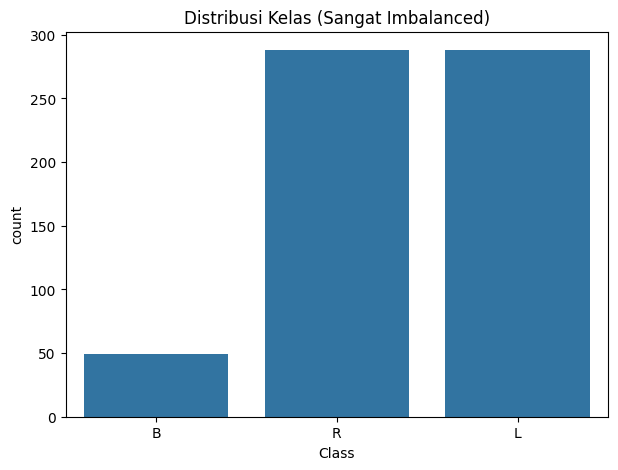

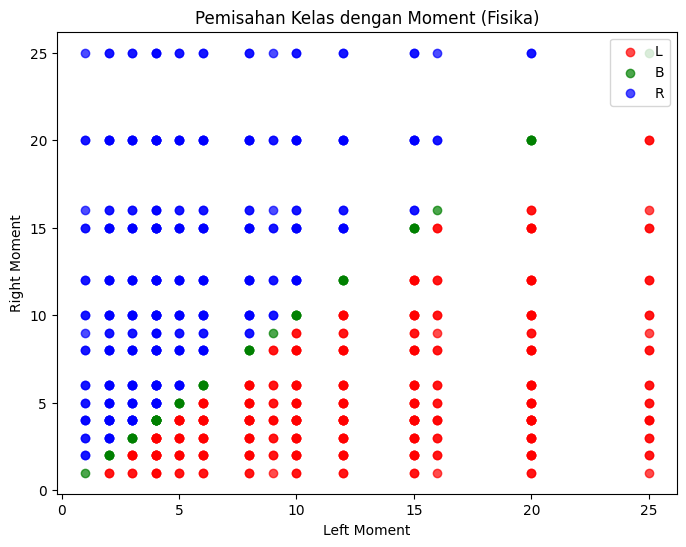

In [ ]:
# Visualisasi 1: Distribusi Kelas
plt.figure(figsize=(7,5))
sns.countplot(x='Class', data=df)
plt.title('Distribusi Kelas (Sangat Imbalanced)')
plt.savefig('../images/class_distribution.png')
plt.show()

# Visualisasi 2: Scatter Plot Moment
plt.figure(figsize=(8,6))
colors = ['red', 'green', 'blue']
for i, cls in enumerate(['L','B','R']):
    subset = df[df['Class'] == cls]
    plt.scatter(subset['Left_Moment'], subset['Right_Moment'],
                label=cls, c=colors[i], alpha=0.7)
plt.xlabel('Left Moment'); plt.ylabel('Right Moment')
plt.legend(); plt.title('Pemisahan Kelas dengan Moment (Fisika)')
plt.savefig('images/moment_scatter.png')
plt.show()

In [12]:
# ============================================
# MODEL 1: BASELINE - Decision Tree
# ============================================
print("\n=== MODEL 1: Decision Tree (Baseline) ===")
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, pred_dt)
print(f"Akurasi: {acc_dt*100:.2f}%")
print(classification_report(y_test, pred_dt, target_names=le.classes_))


=== MODEL 1: Decision Tree (Baseline) ===
Akurasi: 100.00%
              precision    recall  f1-score   support

           B       1.00      1.00      1.00        10
           L       1.00      1.00      1.00        58
           R       1.00      1.00      1.00        57

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



In [13]:
# ============================================
# MODEL 2: ADVANCED - Random Forest (TERBAIK)
# ============================================
print("\n=== MODEL 2: Random Forest (Advanced) ===")
rf = RandomForestClassifier(n_estimators=500, random_state=42,
                            class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred_rf)
print(f"Akurasi: {acc_rf*100:.2f}% ← TERBAIK")
print(classification_report(y_test, pred_rf, target_names=le.classes_))


=== MODEL 2: Random Forest (Advanced) ===
Akurasi: 87.20% ← TERBAIK
              precision    recall  f1-score   support

           B       0.00      0.00      0.00        10
           L       0.97      0.97      0.97        58
           R       0.87      0.93      0.90        57

    accuracy                           0.87       125
   macro avg       0.61      0.63      0.62       125
weighted avg       0.84      0.87      0.86       125



In [ ]:
# Simpan model
joblib.dump(rf, '../models/model_rf.pkl')

['models/model_rf.pkl']

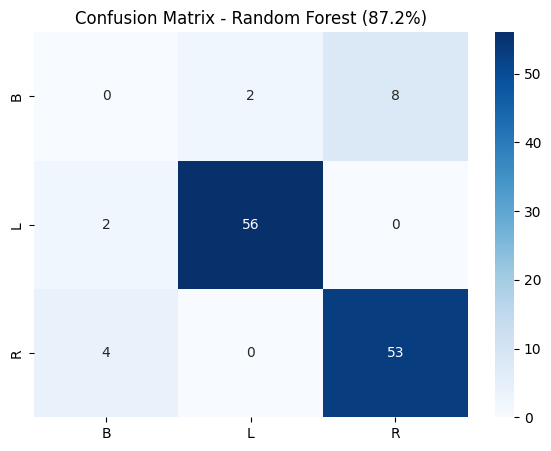

In [16]:
# Confusion Matrix RF
cm = confusion_matrix(y_test, pred_rf)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - Random Forest ({acc_rf*100:.1f}%)')
plt.savefig('images/confusion_matrix_rf.png')
plt.show()

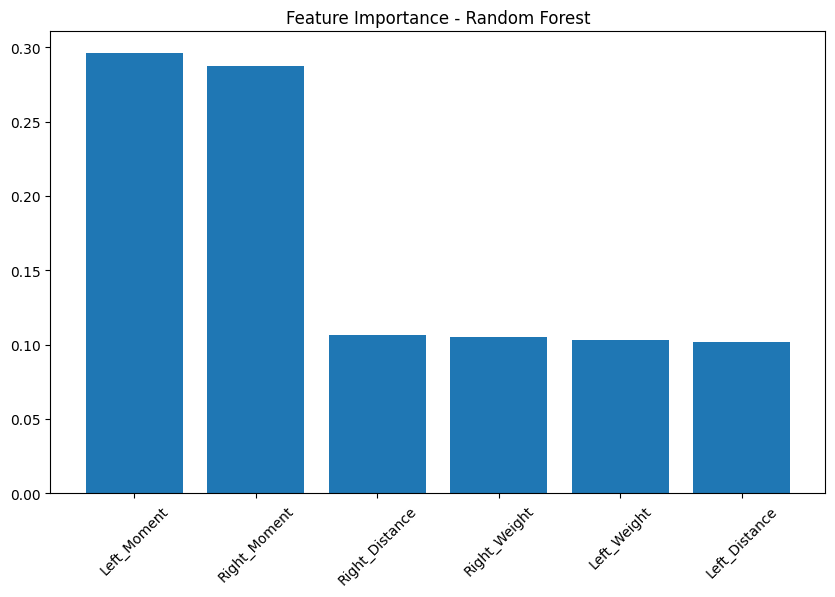

In [ ]:
# Feature Importance
plt.figure(figsize=(10,6))
imp = rf.feature_importances_
idx = np.argsort(imp)[::-1]
plt.bar(range(len(imp)), imp[idx])
plt.xticks(range(len(imp)), [X.columns[i] for i in idx], rotation=45)
plt.title('Feature Importance - Random Forest')
plt.savefig('../images/feature_importance.png')
plt.show()

In [ ]:
# ============================================
# MODEL 3: DEEP LEARNING - MLP
# ============================================
print("\n=== MODEL 3: Deep Learning (MLP) ===")
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_s.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train_s, y_train,
                    validation_split=0.2,
                    epochs=200,
                    batch_size=32,
                    callbacks=[es],
                    verbose=1)

loss, acc_mlp = model.evaluate(X_test_s, y_test, verbose=0)
print(f"Akurasi MLP: {acc_mlp*100:.2f}%")

model.save('../models/model_mlp.h5')


=== MODEL 3: Deep Learning (MLP) ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.3278 - loss: 1.1134 - val_accuracy: 0.8100 - val_loss: 0.8990
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7228 - loss: 0.8465 - val_accuracy: 0.8800 - val_loss: 0.6964
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8129 - loss: 0.6842 - val_accuracy: 0.8700 - val_loss: 0.5137
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8473 - loss: 0.5028 - val_accuracy: 0.8900 - val_loss: 0.3599
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8898 - loss: 0.3416 - val_accuracy: 0.9000 - val_loss: 0.2810
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8948 - loss: 0.3131 - val_accuracy: 0.9100 - val_loss: 0.2286
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9136 - loss: 0.2452 - val_accuracy: 0.9100 - val_loss: 0.1968
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9220 - loss: 0.2308 - val_accuracy: 0.

Akurasi MLP: 99.20%


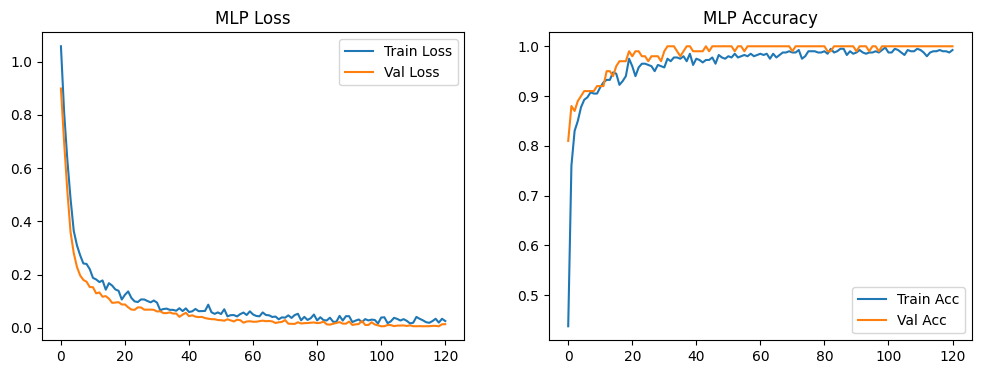

In [ ]:
# Training History
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MLP Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('MLP Accuracy'); plt.legend()
plt.savefig('../images/mlp_training_history.png')
plt.show()

In [20]:
# ============================================
# PERBANDINGAN AKHIR
# ============================================
print("\n=== RINGKASAN PERBANDINGAN ===")
print(f"Decision Tree (Baseline) : {acc_dt*100:.2f}%")
print(f"Random Forest (Advanced) : {acc_rf*100:.2f}% ← TERBAIK")
print(f"MLP Deep Learning        : {acc_mlp*100:.2f}%")
print("\nModel terbaik: Random Forest")


=== RINGKASAN PERBANDINGAN ===
Decision Tree (Baseline) : 100.00%
Random Forest (Advanced) : 87.20% ← TERBAIK
MLP Deep Learning        : 99.20%

Model terbaik: Random Forest
